In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
filepath = "../MiddEval3/trainingQ/"

In [3]:
filenames = os.listdir(filepath)

In [202]:
im0 = cv2.imread("../MiddEval3/trainingQ/Recycle/im0.png", cv2.IMREAD_GRAYSCALE)
im1 = cv2.imread("../MiddEval3/trainingQ/Recycle/im1.png",cv2.IMREAD_GRAYSCALE)

In [203]:
im0.shape, im1.shape

((486, 720), (486, 720))

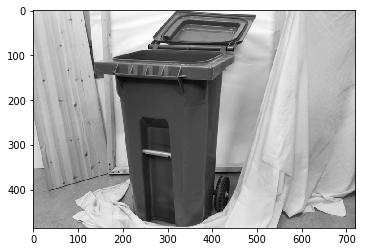

In [204]:
plt.imshow(im0, cmap="gray")
plt.show()

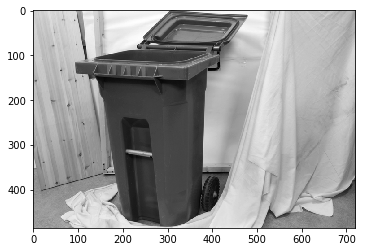

In [205]:
plt.imshow(im1, cmap="gray")
plt.show()

In [256]:
def ab_loss(mat1, mat2):
    r, c = mat2.shape
    return np.sum(np.abs(mat1[:r, :c] - mat2))

def sq_loss(mat1, mat2):
    r, c = mat2.shape
    return np.sum(np.square(mat1[:r, :c]-mat2))

In [225]:
def compute_disparity(im1, im0, d_max, W, loss):
    patch = im1
    strt = 0
    imshape = im0.shape
    disp_arr = []
    while strt < imshape[1]:# and strt < d_max:
        disp_arr.append(loss(patch, im0[:, strt:strt+W]))
        strt+=1
    return np.array(disp_arr).argmin()

In [249]:
def compute_disparity_map(im1, im0, loss, W, d_max=75):
    disparity = np.zeros_like(im1)
    cur_pixel = [0, 0]
    im_shape = im1.shape
    while cur_pixel[0] < im_shape[0]:
        while cur_pixel[1] < im_shape[1]:
            a,b = max(0,cur_pixel[0]-W//2), max(0,cur_pixel[1]-W//2)
            c,d = min(im_shape[0], cur_pixel[0]+W//2), min(im_shape[1], cur_pixel[1]+W//2)
            disparity[tuple(cur_pixel)] = compute_disparity(im1[a:c, b:d], im0[a:c, :], d_max, d-b, loss)
            cur_pixel[1]+=1
        cur_pixel[1] = 0
        cur_pixel[0]+=1
    return disparity

In [213]:
result = compute_disparity_map(im1,im0, ab_loss, 7)

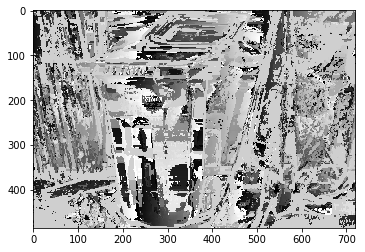

In [215]:
plt.imshow(result, cmap="gray")
plt.show()

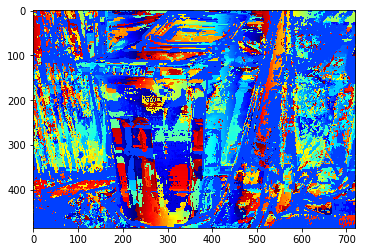

In [216]:
plt.imshow(cv2.applyColorMap(result, cv2.COLORMAP_JET))
plt.show()

In [217]:
cv2.imwrite("abs_loss.jpg", result)

True

In [257]:
result = compute_disparity_map(im1,im0, sq_loss, 7)

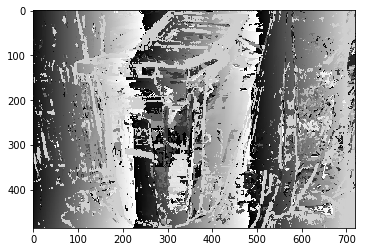

In [258]:
plt.imshow(result, cmap="gray")
plt.show()

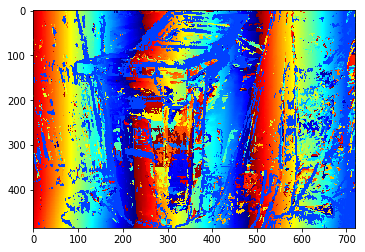

In [259]:
plt.imshow(cv2.applyColorMap(result, cv2.COLORMAP_JET))
plt.show()

In [260]:
cv2.imwrite("sq_loss.jpg", result)

True

In [261]:
def elastic_net(mat1, mat2, r=0.5):
    r, c = mat2.shape
    return np.sum(np.abs(mat1[:r, :c] - mat2))*r + (1-r)*np.sum(np.square(mat1[:r, :c]-mat2))

In [263]:
result = compute_disparity_map(im1,im0, elastic_net, 7)

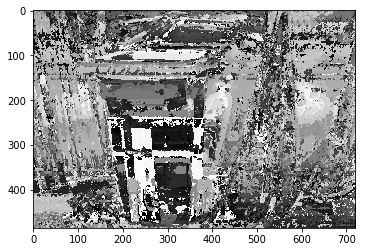

In [264]:
plt.imshow(result, cmap="gray")
plt.show()

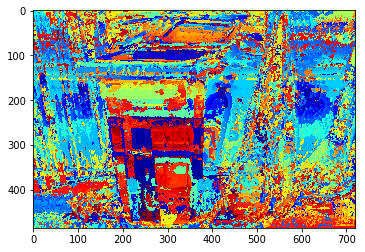

In [265]:
plt.imshow(cv2.applyColorMap(result, cv2.COLORMAP_JET))
plt.show()

In [266]:
cv2.imwrite("elastic_net_loss.jpg", result)

True

### Evaluation

Here we are calculating the RMSE between the ground truth disparity with the one that is generated using different loss functions.
* sum absolute loss
* sum squared loss
* elastic loss or combination of both

In [267]:
groundtruth = cv2.imread("../MiddEval3/trainingQ/Recycle/mask0nocc.png", cv2.IMREAD_GRAYSCALE)
sum_squared_loss = cv2.imread("./sq_loss.jpg", cv2.IMREAD_GRAYSCALE)
sum_abs_loss = cv2.imread("./abs_loss.jpg", cv2.IMREAD_GRAYSCALE)
elastic_loss = cv2.imread("./elastic_net_loss.jpg", cv2.IMREAD_GRAYSCALE)

In [277]:
print("RMSE of Sum Squared Loss:", np.sqrt(np.mean(np.square(groundtruth-sum_squared_loss))))
print("RMSE of Sum Abs Loss:", np.sqrt(np.mean(np.square(groundtruth-sum_abs_loss))))
print("RMSE of Elastic Loss:", np.sqrt(np.mean(np.square(groundtruth-elastic_loss))))

RMSE of Sum Squared Loss: 10.150587844298446
RMSE of Sum Abs Loss: 10.015652901368687
RMSE of Elastic Loss: 10.334686595533126


Here we can see that, 10.015 is the least RMSE error among the loss function we used. Hence, among sum squared loss, sum abs loss and elastic loss, **sum abs loss** is the best performing metric for disparity block matching.

#### TIME AND SPACE COMPLEXITY

The algorithm of "compute_disparity" has time complexity **O(n<sup>3</sup>)**, and space complexity **O(n<sup>3</sup>)**.
Here, we can implement maximum d for which the matching has to be taken in exchange for low accurate disparity maps. But we here have implemented ```d = im.shape[0]```, i.e the whole width.